In [447]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

%matplotlib inline

# Linear model part

In [399]:
data = pd.read_csv('C:/Users/dmitr/Desktop/Metrics_HW/country_profile_variables.csv')

В данной работе будет рассмотрено влияние факторов благосостояния страны на процент мигрантов. Вполне логично ожидать существенные притоки мигрантов в старны, которые признаны более благополучными.  
Для этого в качестве зависимой перемнной будет использоваться `International migrant stock`. В состав регрессоров опредеим:
1. ВВП на душу населения (`GDP per capita`) и квадрат соответствущей переменной как основной индикатор благосотояния;
2. Показетль безработицы (`Unemployment`), который может продемонстрировать обеспеченность страны рабочими местами и их соответствие структуре экономики. Для потенциального мигранта это может бфть косвенным индикатором того, насколько легко ему будет найти работу;
3. Отношение экспорта к ВВП (`Exports` \ `GDP`) и бинарная перменная `Status` (1 - экспортер, 0 - импортер), построенная по платежному балансу страны. Менее развитые страны в целом вынуждены импортировать больше проудкции из-за возможной неспособности наладить нужное производство самостоятельно;
4. Ожидаемая продолжительность жизни (`Life expectancy at birth`), которая может продемонстрировать качество условий жизни в стране и качество работы сферы здравоохранения;
5. Расходы государства на здравоохранение и образование (`Education: government expenditure`, `Health: government expenditure`) по отношению к ВВП страны как одни из основных показателей социальной политики страны;
6. Процент городского населения (`Urban population`) может пригодиться с двух точек зрения. Во-первых, как правило, более урбанизированные страны обладают более развитой экономикой. Во-вторых, подавляющее большинство мигрантов будет стремиться переехать именно в города: больше возможностей найти работу + некоторое повышение социального статуса.

Далее следует обработка данных с вкраплением комментов в коде

In [400]:
data = data[['country', 'Region', 'International migrant stock (000/% of total pop.)', 'Sex ratio (m per 100 f, 2017)','GDP per capita (current US$)', 'Unemployment (% of labour force)', 'Balance of payments, current account (million US$)', 'International trade: Exports (million US$)', 'GDP: Gross domestic product (million current US$)', 'Life expectancy at birth (females/males, years)', 'Education: Government expenditure (% of GDP)', 'Health: Total expenditure (% of GDP)', 'Urban population (% of total population)']]
data.head(5)

,country,Region,International migrant stock (000/% of total pop.),"Sex ratio (m per 100 f, 2017)",GDP per capita (current US$),Unemployment (% of labour force),"Balance of payments, current account (million US$)",International trade: Exports (million US$),GDP: Gross domestic product (million current US$),"Life expectancy at birth (females/males, years)",Education: Government expenditure (% of GDP),Health: Total expenditure (% of GDP),Urban population (% of total population)
0,Afghanistan,SouthernAsia,382.4/1.2,106.3,623.2,8.6,-5121,1458,20270,63.5/61.0,3.3,8.2,26.7
1,Albania,SouthernEurope,57.6/2.0,101.9,3984.2,15.8,-1222,1962,11541,79.9/75.6,3.5,5.9,57.4
2,Algeria,NorthernAfrica,242.4/0.6,102.0,4154.1,11.4,-27229,29992,164779,76.5/74.1,...,7.2,70.7
3,American Samoa,Polynesia,23.2/41.8,103.6,-99.0,...,-99,-99,-99,77.8/71.1,-99,-99.0,87.2
4,Andorra,SouthernEurope,42.1/59.7,102.3,39896.4,-99,-99,100,2812,-99,3.3,8.1,85.1


In [401]:
#делим проценты и абслютные величины на разные столбцы
data[['Migration (th.)', 'Migration (%)']] = data['International migrant stock (000/% of total pop.)'].str.split('/', expand = True)
data = data.drop('International migrant stock (000/% of total pop.)', axis = 1)
data[['Life exp (f)','Life exp (m)']] = data['Life expectancy at birth (females/males, years)'].str.split('/', expand = True)
data = data.drop('Life expectancy at birth (females/males, years)', axis = 1)
data.replace(to_replace = ['-99','-99.0', '...'], value = np.nan, inplace = True)
data.head()

,country,Region,"Sex ratio (m per 100 f, 2017)",GDP per capita (current US$),Unemployment (% of labour force),"Balance of payments, current account (million US$)",International trade: Exports (million US$),GDP: Gross domestic product (million current US$),Education: Government expenditure (% of GDP),Health: Total expenditure (% of GDP),Urban population (% of total population),Migration (th.),Migration (%),Life exp (f),Life exp (m)
0,Afghanistan,SouthernAsia,106.3,623.2,8.6,-5121,1458,20270,3.3,8.2,26.7,382.4,1.2,63.5,61.0
1,Albania,SouthernEurope,101.9,3984.2,15.8,-1222,1962,11541,3.5,5.9,57.4,57.6,2.0,79.9,75.6
2,Algeria,NorthernAfrica,102.0,4154.1,11.4,-27229,29992,164779,NaN,7.2,70.7,242.4,0.6,76.5,74.1
3,American Samoa,Polynesia,103.6,-99.0,NaN,NaN,NaN,-99,NaN,-99.0,87.2,23.2,41.8,77.8,71.1
4,Andorra,SouthernEurope,102.3,39896.4,NaN,NaN,100,2812,3.3,8.1,85.1,42.1,59.7,NaN,None


Оставим в выборке данные только по Европе и Азии (два аргумента: поможет избавитьсядо большого количства $NaN$ и выбросов, учитывая большой разрыв между Африкой/Латинской Америкой и остальными по ряду показателей)

In [402]:
data_eur = data[data.Region.str.contains('Europe')]
data_asia = data[data.Region.str.contains('Asia')]
data = data_eur.merge(data_asia, how = 'outer')

In [403]:
data.replace(to_replace = [-99,-99.0, '...',None], value = np.nan, inplace = True) #убираем оставшиеся пропущенные данные

In [404]:
data = data.dropna()
data.columns =['country', 'region','m_to_f', 'GDP per cap', 'unemp', 'BP', 'export', 'GDP', 'edu_exp', 'hea_exp', 'urban', 'migr_th', 'migr_perc', 'lexp_f', 'lexp_m']
data.head(5)

,country,region,m_to_f,GDP per cap,unemp,BP,export,GDP,edu_exp,hea_exp,urban,migr_th,migr_perc,lexp_f,lexp_m
0,Albania,SouthernEurope,101.9,3984.2,15.8,-1222,1962,11541.0,3.5,5.9,57.4,57.6,2.0,79.9,75.6
2,Austria,WesternEurope,96.2,44117.7,6.2,7020,145503,376967.0,5.5,11.2,66.0,1492.4,17.5,83.5,78.4
3,Belarus,EasternEurope,87.0,5750.8,0.5,-2037,23414,54609.0,4.9,5.7,76.7,1082.9,11.4,77.7,66.5
4,Belgium,WesternEurope,97.3,40277.8,8.3,1936,398033,455107.0,6.6,10.6,97.9,1387.9,12.3,83.0,78.0
6,Bulgaria,EasternEurope,94.6,6846.8,8.1,196,26088,48953.0,4.1,8.4,73.9,102.1,1.4,77.8,70.8


In [405]:
data = data.drop(['migr_th'], axis = 1) #будем использовать процент

In [406]:
#расчет взвешенной смертности
data['m_to_f'] = pd.to_numeric(data['m_to_f'])
data['m_to_f'] = data['m_to_f']/ (100 + data['m_to_f'])
data.head()

,country,region,m_to_f,GDP per cap,unemp,BP,export,GDP,edu_exp,hea_exp,urban,migr_perc,lexp_f,lexp_m
0,Albania,SouthernEurope,0.504705,3984.2,15.8,-1222,1962,11541.0,3.5,5.9,57.4,2.0,79.9,75.6
2,Austria,WesternEurope,0.490316,44117.7,6.2,7020,145503,376967.0,5.5,11.2,66.0,17.5,83.5,78.4
3,Belarus,EasternEurope,0.465241,5750.8,0.5,-2037,23414,54609.0,4.9,5.7,76.7,11.4,77.7,66.5
4,Belgium,WesternEurope,0.493158,40277.8,8.3,1936,398033,455107.0,6.6,10.6,97.9,12.3,83.0,78.0
6,Bulgaria,EasternEurope,0.486125,6846.8,8.1,196,26088,48953.0,4.1,8.4,73.9,1.4,77.8,70.8


In [407]:
data['GDP per cap'] = pd.to_numeric(data['GDP per cap'])
data['unemp'] = pd.to_numeric(data['unemp'])
data['edu_exp'] = pd.to_numeric(data['edu_exp'])
data['hea_exp'] = pd.to_numeric(data['hea_exp'])
data['urban'] = pd.to_numeric(data['urban'])
data['migr_perc'] = pd.to_numeric(data['migr_perc'])
data['lexp_f'] = pd.to_numeric(data['lexp_f'])
data['lexp_m'] = pd.to_numeric(data['lexp_m'])
data['l_exp'] = data['m_to_f']*data['lexp_m']+(1-data['m_to_f'])*data['lexp_f']

In [408]:
data = data.drop(['m_to_f', 'lexp_m', 'lexp_f'], axis = 1)

In [409]:
#экспорт к ВВП
data['export to GDP'] = ''
data['export'] = pd.to_numeric(data['export'])
data['GDP'] = pd.to_numeric(data['GDP'])
data['export to GDP'] = data['export'].div(data['GDP'])

In [410]:
data = data.drop(['export', 'GDP'], axis = 1)

In [411]:
data['BP'] = pd.to_numeric(data['BP'])
data.loc[data['BP'] > 0, 'BP'] = 1
data.loc[data['BP'] < 0, 'BP'] = 0

In [412]:
data.head(5)

,country,region,GDP per cap,unemp,BP,edu_exp,hea_exp,urban,migr_perc,l_exp,export to GDP
0,Albania,SouthernEurope,3984.2,15.8,0,3.5,5.9,57.4,2.0,77.729767,0.170003
2,Austria,WesternEurope,44117.7,6.2,1,5.5,11.2,66.0,17.5,80.999388,0.385983
3,Belarus,EasternEurope,5750.8,0.5,0,4.9,5.7,76.7,11.4,72.489305,0.428757
4,Belgium,WesternEurope,40277.8,8.3,1,6.6,10.6,97.9,12.3,80.534212,0.874592
6,Bulgaria,EasternEurope,6846.8,8.1,1,4.1,8.4,73.9,1.4,74.397122,0.532919


In [413]:
#масштаб
from sklearn.preprocessing import StandardScaler
num_data = data.drop(['country', 'region'], axis = 1)
cols = num_data.columns.to_list()
scaler = StandardScaler()
data_new = scaler.fit_transform(num_data)
data_new = pd.DataFrame(data_new)
data_new.columns = cols
data_new

,GDP per cap,unemp,BP,edu_exp,hea_exp,urban,migr_perc,l_exp,export to GDP
0,-0.774381,2.238934,-1.060660,-0.782222,-0.417955,-0.333838,-0.709547,0.367978,-0.759185
1,1.014820,-0.103711,0.942809,0.478231,1.479161,0.067289,0.407499,1.001711,0.134171
2,-0.695624,-1.494656,-1.060660,0.100095,-0.489544,0.566366,-0.032112,-0.647753,0.311095
3,0.843632,0.408743,0.942809,1.171480,1.264393,1.555191,0.032748,0.911548,2.155191
4,-0.646763,0.359938,0.942809,-0.404086,0.476911,0.435766,-0.752787,-0.277971,0.741938
5,-0.440236,1.238429,0.942809,-0.088973,0.262143,-0.259210,0.126436,0.250079,-0.302615
6,-0.169079,-0.664969,0.942809,-0.404086,0.118965,0.393788,-0.579825,0.459347,2.139822
7,1.417460,-0.152516,0.942809,2.431933,1.335983,1.079435,-0.125800,0.839075,-0.167083
8,-0.189127,0.140315,0.942809,0.478231,-0.238982,0.137253,0.256158,0.186736,1.107064
9,0.927013,0.555158,-1.060660,1.549616,0.942242,0.916186,-0.442897,0.951939,-0.440134


Из dataset'а были предварительно исключены все строки с пропущенными значениями

C:\Users\dmitr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\dmitr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


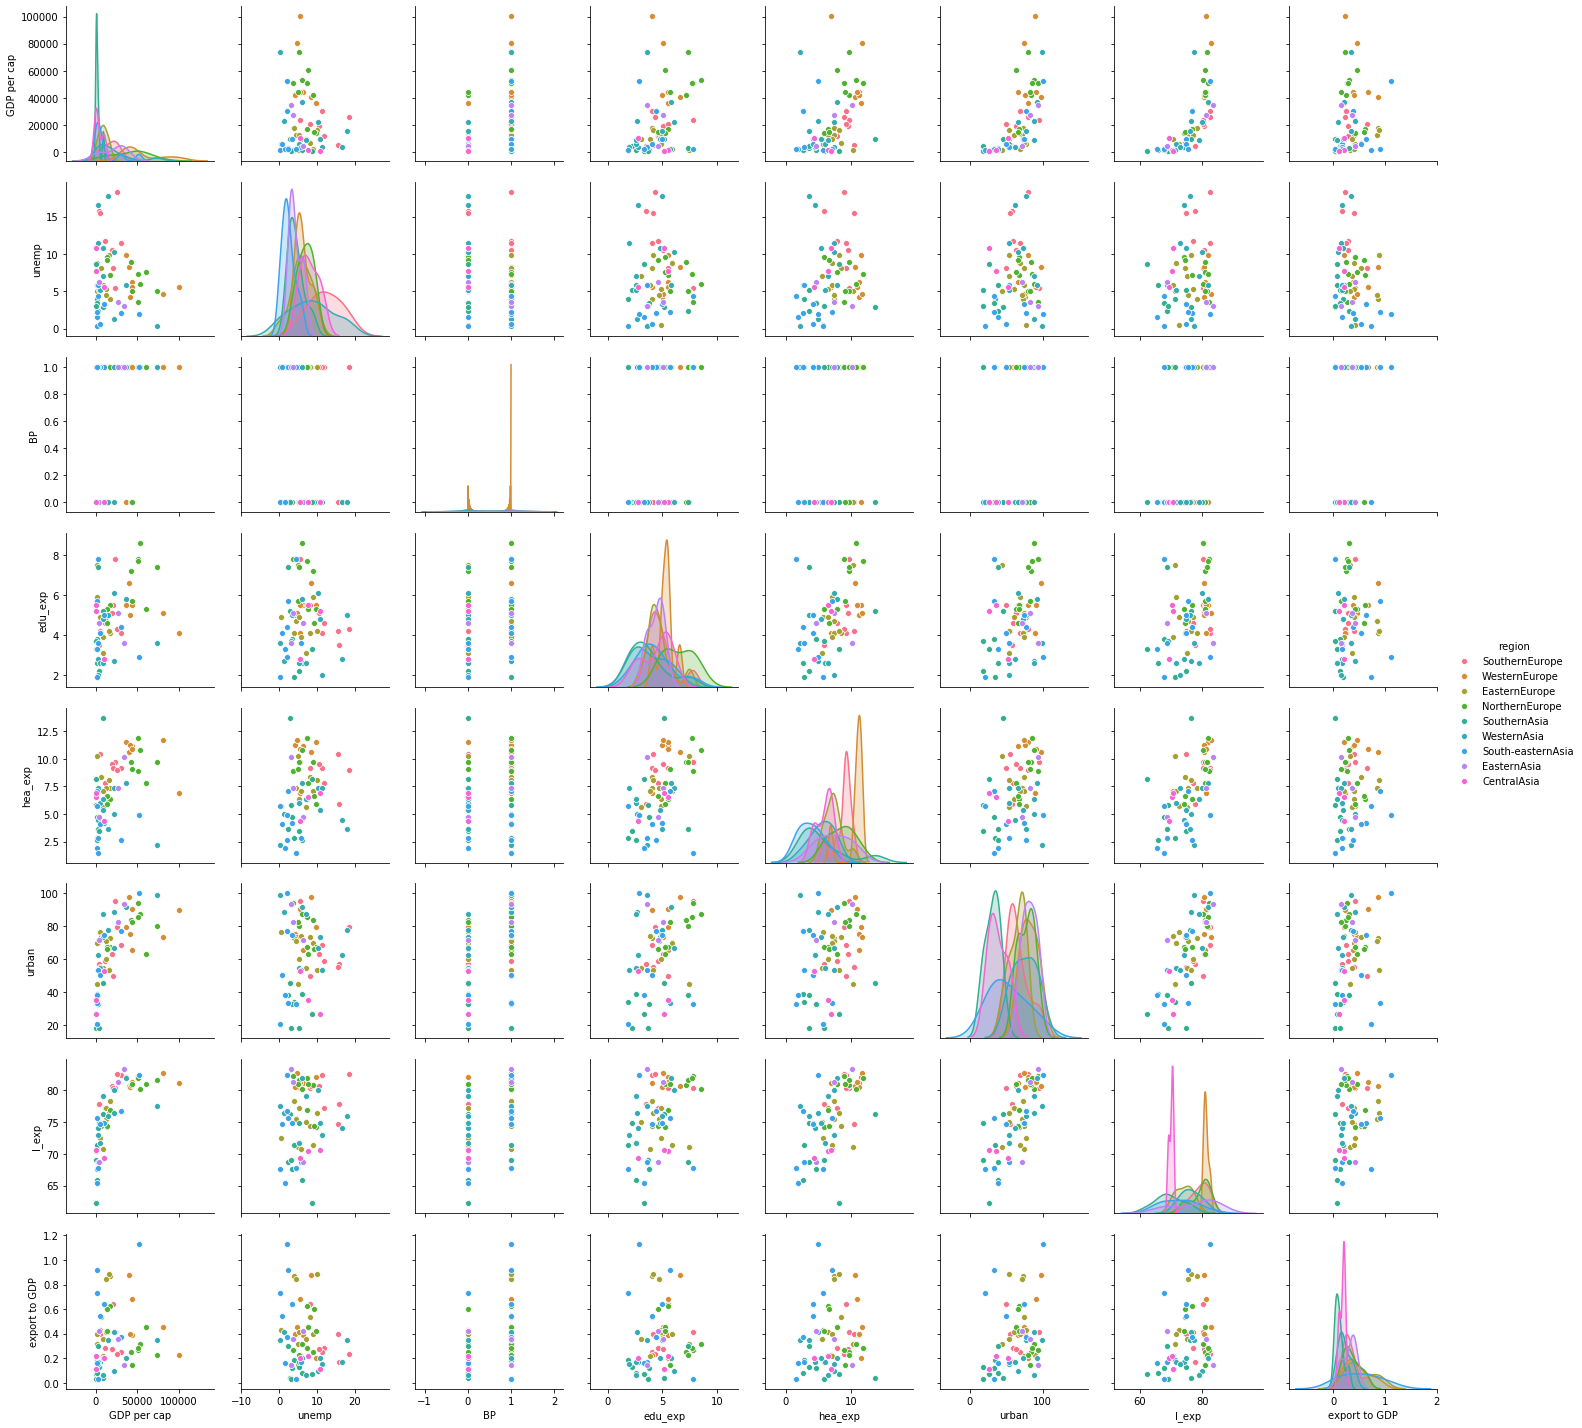

In [393]:
ds = sns.pairplot(data, hue = 'region', palette= 'husl', vars = ['GDP per cap', 'unemp', 'BP','edu_exp','hea_exp','urban','l_exp','export to GDP'])

По данным графикам нельзя сделать вывод о линейной зависимости каких-то из признаков, поэтому очевидной мултиколлинераности нет. Проверим на тестах.

In [414]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xs = data_new[['GDP per cap', 'unemp', 'BP', 'edu_exp', 'hea_exp', 'urban', 'l_exp', 'export to GDP']]

In [415]:
vif = pd.DataFrame()
vif["Переменная"] = Xs.columns
vif["VIF"] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
vif

,Переменная,VIF
0,GDP per cap,2.740394
1,unemp,1.351168
2,BP,1.785717
3,edu_exp,1.329162
4,hea_exp,1.889195
5,urban,2.514921
6,l_exp,4.388825
7,export to GDP,1.281270


In [416]:
from numpy import linalg as la
cn_matrix = Xs.values
cn = np.sqrt(la.cond(cn_matrix, 2)/la.cond(cn_matrix, -2))
cn

4.612824683480011

Анализ VIF и CN не показали практической мультиколлинеарности. Для дальнейших тестов построим оценки МНК:

In [429]:
X = data_new.iloc[:, :].drop(['migr_perc'],axis = 1) #регрессоры
Y = data_new.iloc[:, 6] # зависимая переменная
X_ = sm.add_constant(X)

In [434]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
reg = sm.OLS(Y, X_)
res = reg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              migr_perc   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     7.801
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.42e-07
Time:                        19:45:42   Log-Likelihood:                -71.952
No. Observations:                  68   AIC:                             161.9
Df Residuals:                      59   BIC:                             181.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.388e-17      0.091   1.53e-16      1.000      -0.182       0.182
GDP per cap       0.5753      0.150      3.829      0.000       0.275       0.876
unemp            -0.0165      0.105     -0.157      0.876      -0.228       0.195
BP               -0.0589      0.121     -0.486      0.629      -0.302       0.184
edu_exp          -0.1961      0.105     -1.874      0.066      -0.405       0.013
hea_exp          -0.2420      0.125     -1.940      0.057      -0.492       0.008
urban             0.3579      0.144      2.487      0.016       0.070       0.646
l_exp            -0.0419      0.190     -0.221      0.826      -0.422       0.339
export to GDP    -0.0137      0.103     -0.133      0.894      -0.219       0.192
==============================================================================
Omnibus:                       20.978   Durbin-Watson:                   2.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.009
Skew:                           1.255   Prob(JB):                     5.02e-07
Kurtosis:                       4.984   Cond. No.                         4.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ниже представлены робастные (устойчивые к гетероскедастичности) ошибки для данной регрессионной модели

In [446]:
res.HC0_se

const            0.084537
GDP per cap      0.173383
unemp            0.144669
BP               0.094626
edu_exp          0.099235
hea_exp          0.173104
urban            0.136680
l_exp            0.143750
export to GDP    0.098022
dtype: float64

In [448]:
res.HC1_se

const            0.090756
GDP per cap      0.186138
unemp            0.155312
BP               0.101587
edu_exp          0.106535
hea_exp          0.185838
urban            0.146735
l_exp            0.154325
export to GDP    0.105233
dtype: float64

In [449]:
res.HC2_se

const            0.093176
GDP per cap      0.195659
unemp            0.163189
BP               0.103709
edu_exp          0.108982
hea_exp          0.198228
urban            0.149464
l_exp            0.158123
export to GDP    0.109731
dtype: float64

In [450]:
res.HC3_se

const            0.103054
GDP per cap      0.221276
unemp            0.184408
BP               0.114051
edu_exp          0.119931
hea_exp          0.227253
urban            0.163797
l_exp            0.174526
export to GDP    0.123164
dtype: float64

**Warning** Дальнейшие шаги по этой части я выполнить не успел. Начинал делать эту д\з со второй части (см.ниже)

# Time series Part

**Задание 1**  
Генерируем ряды. Классификация процессов: первый - AR(1), второй - AR(3), третий - MA (2). Каждый ряд считаем честно по соответствующей формуле 
Для построения рядов используются следующие предпосылки:
1. В AR(1) первое наблюдение равно 1
2. В AR(3) первое наблюдение равно 1, второе и третье генерируются как 1+WN(0;1)
3. MA(2) строится на шумах, имеющих распределение WN(0;1)

In [285]:
nums = np.linspace(1, 120, 120)
data1 = pd.DataFrame()
data1['Timestamp'] = nums
data1['Value'] = ''
data1.at[0, 'Value'] = 1
np.random.seed(7)
for x in range(1,len(data1)):
    data1.loc[x, 'Value'] = 0.8 * data1.loc[x-1, 'Value'] + np.random.normal(0,1)

In [286]:
data2 = pd.DataFrame()
data2['Timestamp'] = nums
data2['Value'] = ''
data2.at[0, 'Value'] = 1
data2.at[1, 'Value'] = data2.loc[0, 'Value'] + np.random.normal(0,1)
data2.at[2, 'Value'] = data2.loc[1, 'Value'] + np.random.normal(0,1)
np.random.seed(2)
for y in range(3, len(data2)):
    data2.loc[y, 'Value'] = 0.1 * data2.loc[y-1, 'Value'] + 0.2 * data2.loc[y-2, 'Value'] + 0.3 * data2.loc[y-3, 'Value'] + np.random.normal(0,1)  

In [287]:
data3 = pd.DataFrame()
data3['Timestamp'] = nums
data3['Value'] = ''
np.random.seed(4)
A = [np.random.normal() for i in range(120)]
A = np.array(A)
data3['Noise'] = A
data3.loc[0, 'Value'] = data3.loc[0, 'Noise']
data3.loc[1, 'Value'] = data3.loc[1, 'Noise'] + data3.loc[0, 'Noise']
for q in range(2, len(data3)):
    data3.loc[q, 'Value'] = 1.2 * data3.loc[q-1, 'Noise'] + 2 * data3.loc[q-2, 'Noise'] + data3.loc[q, 'Noise']

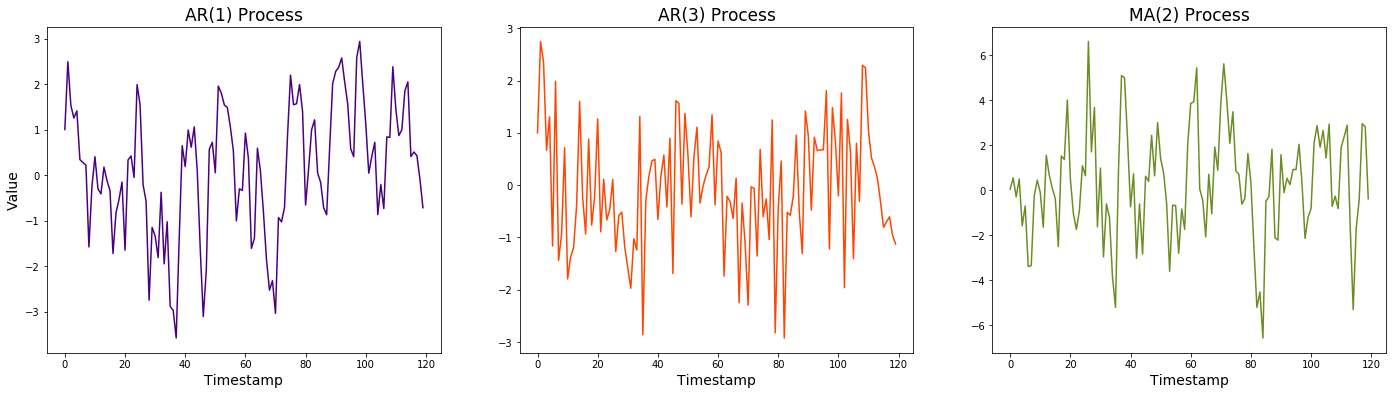

In [288]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (24,6))
ax1.plot(data1.Value,color = 'indigo', linewidth = 1.5)
ax1.set_title('AR(1) Process', fontsize = 17)
ax1.set_xlabel('Timestamp', fontsize = 14)
ax1.set_ylabel('Value', fontsize = 14)
ax2.plot(data2.Value, color = 'orangered', linewidth = 1.5)
ax2.set_title('AR(3) Process', fontsize = 17)
ax2.set_xlabel('Timestamp', fontsize = 14)
ax3.plot(data3.Value, color = 'olivedrab', linewidth = 1.5)
ax3.set_title('MA(2) Process', fontsize = 17)
ax3.set_xlabel('Timestamp', fontsize = 14)
plt.show()

При первом взгляде на картинки можно сделать вывод о том, что все изображенные процессы стационарные.  На соответствующих рисунках апмлитуда колебаний приблизительно одинакова для разных периодов времени (аргкмент за фиксированную дисперсию). Более того, не наблюдается устойчивого тренда к росту, как, например, на третьем графике (аргумент в пользу фиксированного мат.ожидания).  
Дополнительная проверка с применением знаний курса: соответствующие харакеристические уравнения для первых всех процессов не имеют корней, которые по модулю превышают 1 => процессы являются стационарными.

**Задание 2**

ARIMA(0,1,2) - это процесс MA(2) в разностях первой степени.  
ARIMA(0,0,0) - белый шум. Первый параметр дает понять, что в уравнении процесса нет лагов `y`. Второй параметр Третий параметр показывает, что нет лагов ошибки.  
ARIMA(3,0,0) соответствует процессу AR(3), который уже построен выше.

In [289]:
# готовим ARIMA(0,1,2) из имеющегося MA(2):
data3['Value_ARIMA'] = ''
data3.loc[0, 'Value_ARIMA'] = data3.loc[0, 'Noise']
data3.loc[1, 'Value_ARIMA'] = data3.loc[1, 'Noise'] + 0.2 * data3.loc[0, 'Noise']
data3.loc[2, 'Value_ARIMA'] = data3.loc[2, 'Noise'] + 0.2 * data3.loc[1, 'Noise'] + 0.8 * data3.loc[0, 'Noise']
for t in range(3, len(data3)):
    data3.loc[t, 'Value_ARIMA'] = data3.loc[t-1, 'Noise'] + 0.2 * data3.loc[t-2, 'Noise'] + 0.8 * data3.loc[t-3, 'Noise']
#заодно для построения ARIMA(0,0,0) можно использовать значения, сгенирированные как White Noise внутри этого же сета (столбец Noise)

Построим аналогичные графики для процессов ARIMA:

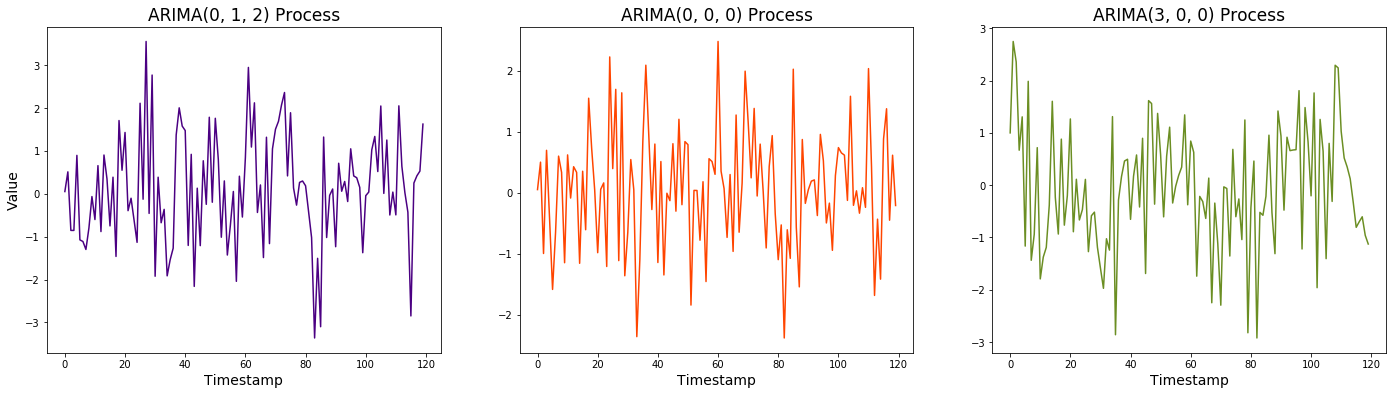

In [290]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (24,6))
ax1.plot(data3.Value_ARIMA,color = 'indigo', linewidth = 1.5)
ax1.set_title('ARIMA(0, 1, 2) Process', fontsize = 17)
ax1.set_xlabel('Timestamp', fontsize = 14)
ax1.set_ylabel('Value', fontsize = 14)
ax2.plot(data3.Noise, color = 'orangered', linewidth = 1.5)
ax2.set_title('ARIMA(0, 0, 0) Process', fontsize = 17)
ax2.set_xlabel('Timestamp', fontsize = 14)
ax3.plot(data2.Value, color = 'olivedrab', linewidth = 1.5)
ax3.set_title('ARIMA(3, 0, 0) Process', fontsize = 17)
ax3.set_xlabel('Timestamp', fontsize = 14)
plt.show()

**Задание 3**
Задаем случайное блуждание:

In [291]:
data4 = pd.DataFrame()
data4['Timestamp'] = nums
data4['Value'] = ''
data4.at[0, 'Value'] = 1
np.random.seed(17)
for x in range(1,len(data1)):
    data4.loc[x, 'Value'] = data4.loc[x-1, 'Value'] + np.random.normal(0,1)

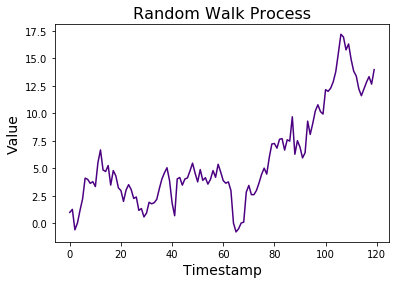

In [292]:
plt.plot(data4.Value,color = 'indigo', linewidth = 1.5)
plt.title('Random Walk Process', fontsize = 16)
plt.xlabel('Timestamp', fontsize = 14)
plt.ylabel('Value', fontsize = 14)
plt.show()

По графику заметно, что данный ряд не является стационарным: например, заметно, что мат.ожидание значения функции в первых периодах не равно ожиданию в последних. Значит, нарушается условие стационарности в широком смысле. Корень соотвестствующего характеристического уравнения равен 1, что не удовлетворяет условию стационарности.

**Задание 4**
Ряд AR(1) был построен нами в первом пункте. Будем использовать те же значения из сета `data1`

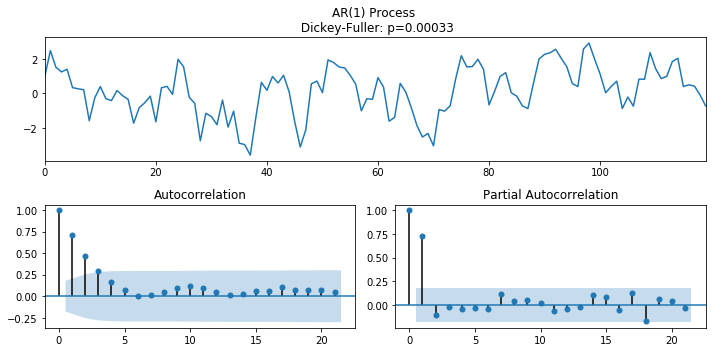

In [293]:
fig = plt.figure(figsize = (10, 5))
layout = (2, 2)
series = plt.subplot2grid(layout, (0, 0), colspan=2)
acf = plt.subplot2grid(layout, (1, 0))
pacf = plt.subplot2grid(layout, (1, 1))
data1.Value.plot(ax = series)
p_value = sm.tsa.stattools.adfuller(data1.Value)[1]
series.set_title('AR(1) Process \n Dickey-Fuller: p={0:.5f}'.format(p_value))
smt.graphics.plot_acf(np.cast[float](data1.Value.values), lags = None, ax = acf)
smt.graphics.plot_pacf(np.cast[float](data1.Value.values), lags = None, ax = pacf)
plt.tight_layout()

Для процессов типа AR(p) характерно экспоненциальное убывание ACF и статистически значенимая PACF только для $k$>$p$. В данном случае $p$=1. Условия выполняются, подтверждая, что мы имеем дело с AR(1)

**Задание 5**
Генерируем ряд ARIMA(2,0,3):  
$y_{t}=0.6y_{t-1}+0.4y_{t-2}+\epsilon_{t}+0.3\epsilon_{t-1}+0.2\epsilon_{t-2}+0.1\epsilon_{t-3}$  
Учитывая то, что степень интеграции 0, можем воспользоваться пакетной реализацией модели $ARMA(2;3)$

**а)** Генерируем значения

In [322]:
np.random.seed(286)
ar_coef = np.array([0.5, 0.4])
ma_coef = np.array([0.3, 0.2, 0.1])
ar = np.r_[1, -ar_coef] 
ma = np.r_[1, ma_coef] 
arma = sm.tsa.ArmaProcess(ar, ma)
arma_gen = arma.generate_sample(120)

**б)** Делим выборку

In [323]:
data5 = pd.DataFrame()
data5['Value'] = arma_gen

In [324]:
data5_train = data5.drop(data5.index[100:120])
data5_test = data5.drop(data5.index[0:99])

**в)** Оценка

In [325]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(np.asarray(data5_train.Value), order=(2,0,3))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(2, 3)   Log Likelihood                -150.213
Method:                       css-mle   S.D. of innovations              1.076
Date:                Fri, 19 Jun 2020   AIC                            314.425
Time:                        21:52:47   BIC                            332.662
Sample:                             0   HQIC                           321.806
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9694      1.284     -0.755      0.452      -3.486       1.547
ar.L1.y        1.5731      0.464      3.393      0.001       0.664       2.482
ar.L2.y       -0.5941      0.427     -1.391      0.168      -1.431       0.243
ma.L1.y       -0.6871      0.470     -1.461      0.147      -1.609       0.234
ma.L2.y        0.1592      0.114      1.391      0.168      -0.065       0.384
ma.L3.y       -0.1949      0.114     -1.716      0.089      -0.418       0.028
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0604           +0.0000j            1.0604            0.0000
AR.2            1.5873           +0.0000j            1.5873            0.0000
MA.1            1.2576           -0.0000j            1.2576           -0.0000
MA.2           -0.2205           -2.0077j            2.0197           -0.2674
MA.3           -0.2205           +2.0077j            2.0197            0.2674
-----------------------------------------------------------------------------
"""

**г) и д)** Прогнозируем и визуализируем

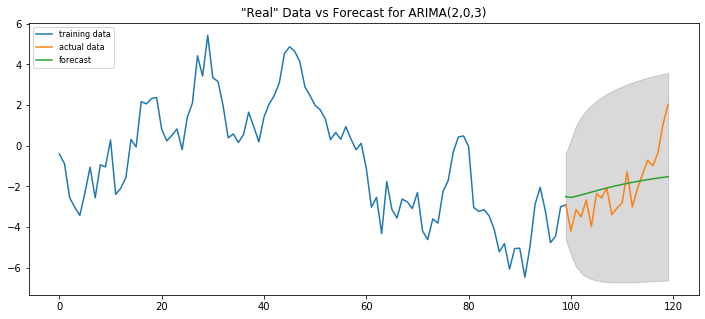

In [326]:
fc, se, conf = model_fit.forecast(21, alpha = 0.05)
fc_series = pd.Series(fc, index=data5_test.index)
lower_series = pd.Series(conf[:, 0], index=data5_test.index)
upper_series = pd.Series(conf[:, 1], index=data5_test.index)

plt.figure(figsize=(12,5))
plt.plot(data5_train.Value, label='training data')
plt.plot(data5_test.Value, label='actual data')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('"Real" Data vs Forecast for ARIMA(2,0,3)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Примечательно, что все 20 реальных значений попали в 95% доверительный интервал. Более того, на данной реализации выборки правильно предсказан повышательный тренд. Прогноз не захватывает существенные колебания из его "сглаживающего" характера.